Instalo las dependecias necesarias:

In [1]:
%%capture
pip install pandas numpy matplotlib seaborn stop-words wordcloud nltk beautifulsoup4 html5lib scikit-learn python-dotenv datasets mlflow

In [2]:
%%capture
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from dotenv import load_dotenv
import os
load_dotenv()
warnings.filterwarnings('ignore')

In [3]:
corpus = load_dataset("somosnlp-hackathon-2023/suicide-comments-es")

In [4]:
type(corpus)

datasets.dataset_dict.DatasetDict

In [5]:
corpus = corpus['train'].to_pandas()

In [6]:
corpus.tail()

,Text,Label
10045,Escriba un código en Python que genere una cad...,0
10046,Genera un título de un libro relacionado con e...,0
10047,Escriba un titular para un artículo de noticia...,0
10048,Mi restaurante favorito es uno que sirve comid...,0
10049,Crea una ecuación matemática que represente la...,0


In [7]:
corpus.rename(columns={'Text':'text', 'Label':'label'}, inplace=True)

In [8]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10050 non-null  object
 1   label   10050 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.2+ KB


In [9]:
corpus['label'].value_counts()

label
0    9273
1     777
Name: count, dtype: int64

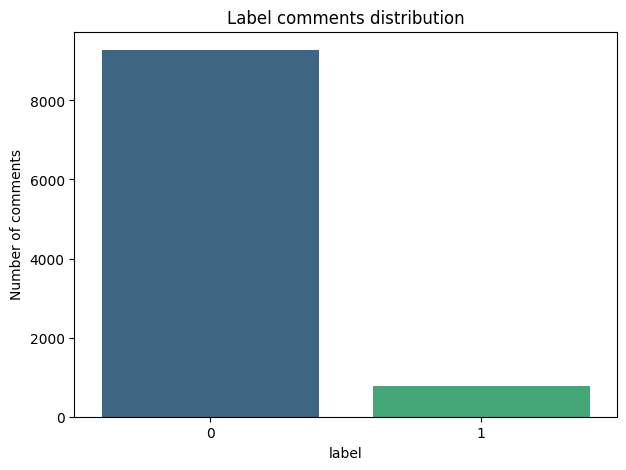

In [10]:
plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=corpus, palette="viridis")
plt.title('Label comments distribution')
plt.xlabel('label')
plt.ylabel('Number of comments')
plt.show()

Se observa un claro desbalanceo de clases, lo que entra dentro de la normalidad dada la temática que estamos tratando.

In [11]:
words = []

for text in corpus['text']:

  words_current = str(text).lower().split()
  words.extend(words_current)

vocab = set(words)
cardinality = len(vocab)

print(f"Cardinalidad del vocabulario (palabras únicas): {cardinality}")

Cardinalidad del vocabulario (palabras únicas): 20902


In [12]:
from stop_words import get_stop_words

sw = get_stop_words(language = 'es')

final_words = [word for word in words if word not in sw]

In [13]:
final_vocab = set(final_words)
final_cardinality = len(final_vocab)

print(f"Cardinalidad del vocabulario sin stop words: {final_cardinality}")

Cardinalidad del vocabulario sin stop words: 20439


In [14]:
from wordcloud import WordCloud

In [15]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

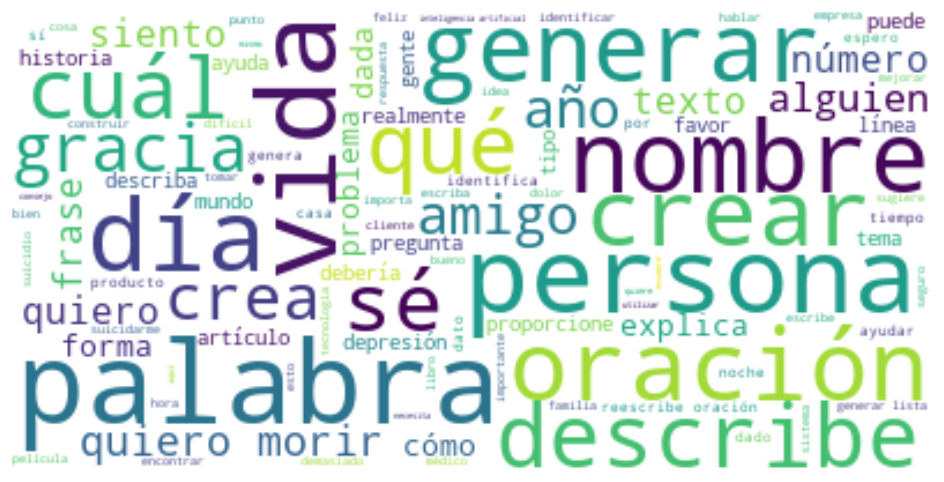

In [16]:
plot_word_cloud(final_words)

Procedo ahora a la vectorización del corpus, con una fase previa de preprocesamiento del mismo.

In [17]:
%%capture
import string
import nltk
import re
import pandas as pd
from bs4 import BeautifulSoup
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

In [18]:
stopwords_es = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

In [19]:
def preprocessing(text):
  """
  It drops empty texts, NaN, HTML, URLs, numbers and special caracters.
  """

  if not text or text.lower() in ['none', 'nan']:
        return ""

  text = BeautifulSoup(text, "html5lib").get_text()

  text = re.sub(r'https?://\S+|www\.\S+', '', text)

  text = re.sub(r"[^^a-zñáéíóúü]", " ", text.lower())

  text = re.sub(r'\d+', '', text)

  return text

In [20]:
def tokenize_lemmatize(text):
    """
    Tokenize, drops stopwords and lemamatize.
    """

    tokens = nltk.word_tokenize(text)

    tokens = [word for word in tokens if word not in stopwords_es]

    lemas = []
    for word, tag in nltk.pos_tag(tokens):

        if tag.startswith('J'):
            pos = 'a'
        elif tag.startswith('V'):
            pos = 'v'
        elif tag.startswith('N'):
            pos = 'n'
        elif tag.startswith('R'):
            pos = 'r'
        else:
            pos = 'n'

        lemas.append(lemmatizer.lemmatize(word, pos=pos))

    return " ".join(lemas)

In [21]:
def preprocessing_main(review_text):
    """
    Main function of the full pipeline.
    """
    text_processed = preprocessing(review_text)
    text_final = tokenize_lemmatize(text_processed)

    return text_final

In [22]:
corpus_mod = corpus.copy()
corpus_mod['text_processed'] = corpus_mod['text'].apply(preprocessing_main)

Veo si se ha aplicado correctamente:

In [23]:
print('Original review: {}'.format(corpus_mod['text'][1]))
print('Processed review: {}'.format(corpus_mod["text_processed"][1]))

Original review: Las mujeres son extrañas, sé lo que quieres decir, cuando me dejaron, no me lo esperaba.
Processed review: mujeres extrañas sé quieres decir dejaron esperaba


In [24]:
corpus_mod.to_json("corpus_mod.json")

Realizamos la división del corpus en train / test / val:

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split

In [26]:
X = corpus_mod['text_processed']
y = corpus_mod['label']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=0
)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=0
)

In [29]:
sets = {"X_train": X_train,"y_train": y_train,"X_val": X_val,
    "y_val": y_val,"X_test": X_test,"y_test": y_test}

for name, set_ in sets.items():
    print(f"Number of rows in {name}: {set_.shape[0]}")

Number of rows in X_train: 7260
Number of rows in y_train: 7260
Number of rows in X_val: 1282
Number of rows in y_val: 1282
Number of rows in X_test: 1508
Number of rows in y_test: 1508


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
cv = TfidfVectorizer(
    ngram_range=(1, 3),
    max_df=0.9,
    min_df=10
)

In [32]:
print(cv.fit(X_train))

TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 3))


In [33]:
feature_names = cv.get_feature_names_out()
print(f"Tamaño del vocabulario (Número de features): {len(feature_names)}")

Tamaño del vocabulario (Número de features): 1166


In [34]:
X_train_tfidf = cv.fit_transform(X_train)
X_test_tfidf = cv.transform(X_test)

Utilizo una simple regresión logística, que será más que suficiente:

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train_tfidf, y_train)

    train_predict = lr.predict(X_train_tfidf)
    test_predict = lr.predict(X_test_tfidf)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9177718832891246
Accuracy for C=0.05: 0.9237400530503979
Accuracy for C=0.25: 0.9370026525198939
Accuracy for C=0.5: 0.9476127320954907
Accuracy for C=1: 0.9588859416445623
Accuracy for C=10: 0.9602122015915119
Accuracy for C=100: 0.9595490716180372
Accuracy for C=1000: 0.9515915119363395
Accuracy for C=10000: 0.9529177718832891


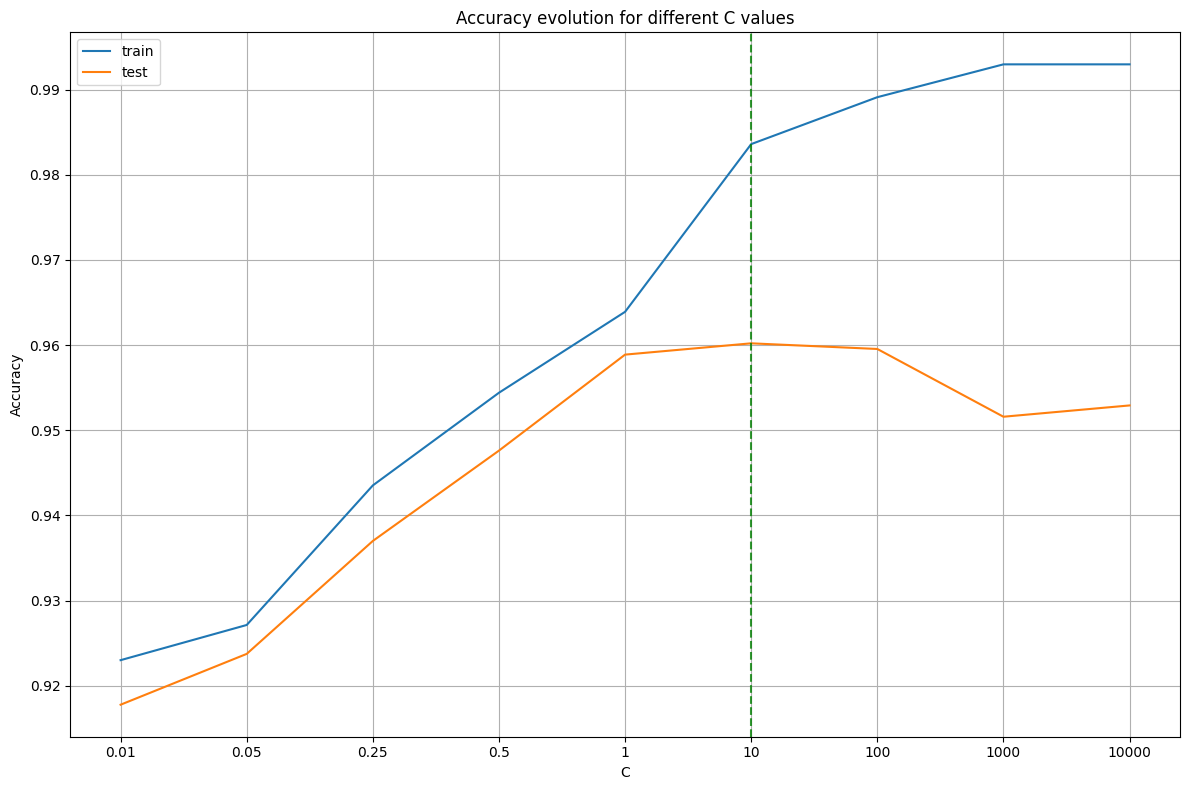

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

La gráfica refleja que el mejor modelo se encuentra con C=10.

In [37]:
lr_model = LogisticRegression(C=10, max_iter=1000, random_state=0)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_train_lr = lr_model.predict(X_train_tfidf)

In [38]:
print("\n=============================================")
print("### 1. Regresión Logística (TF-IDF) ###")
print("=============================================")
print('\nConfussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred_lr)))
print(f"\nAccuracy train (Exactitud): {accuracy_score(y_train, y_train_lr):.4f}")
print(f"\nAccuracy test (Exactitud): {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_lr))


### 1. Regresión Logística (TF-IDF) ###

Confussion matrix:
[[1361   23]
 [  37   87]]

Accuracy train (Exactitud): 0.9836

Accuracy test (Exactitud): 0.9602

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1384
           1       0.79      0.70      0.74       124

    accuracy                           0.96      1508
   macro avg       0.88      0.84      0.86      1508
weighted avg       0.96      0.96      0.96      1508



A continuación, utilizaremos MLFlow para trackear estas métricas.

In [39]:
import mlflow

In [40]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment('suicide_analysis')

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1769789645343, experiment_id='2', last_update_time=1769789645343, lifecycle_stage='active', name='suicide_analysis', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [41]:
%%capture
for c in c_params:

    with mlflow.start_run(run_name=f"LogisticRegression_C{c}"):
        
        lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000, random_state=0)
        lr.fit(X_train_tfidf, y_train)

        train_predict = lr.predict(X_train_tfidf)
        test_predict = lr.predict(X_test_tfidf)

        acc_train = accuracy_score(y_train, train_predict)
        acc_test = accuracy_score(y_test, test_predict)

        mlflow.log_param("C", c)
        mlflow.log_param("solver", "lbfgs")
        mlflow.log_param("max_iter", 1000)
        
        mlflow.log_metric("accuracy_train", acc_train)
        mlflow.log_metric("accuracy_test", acc_test)

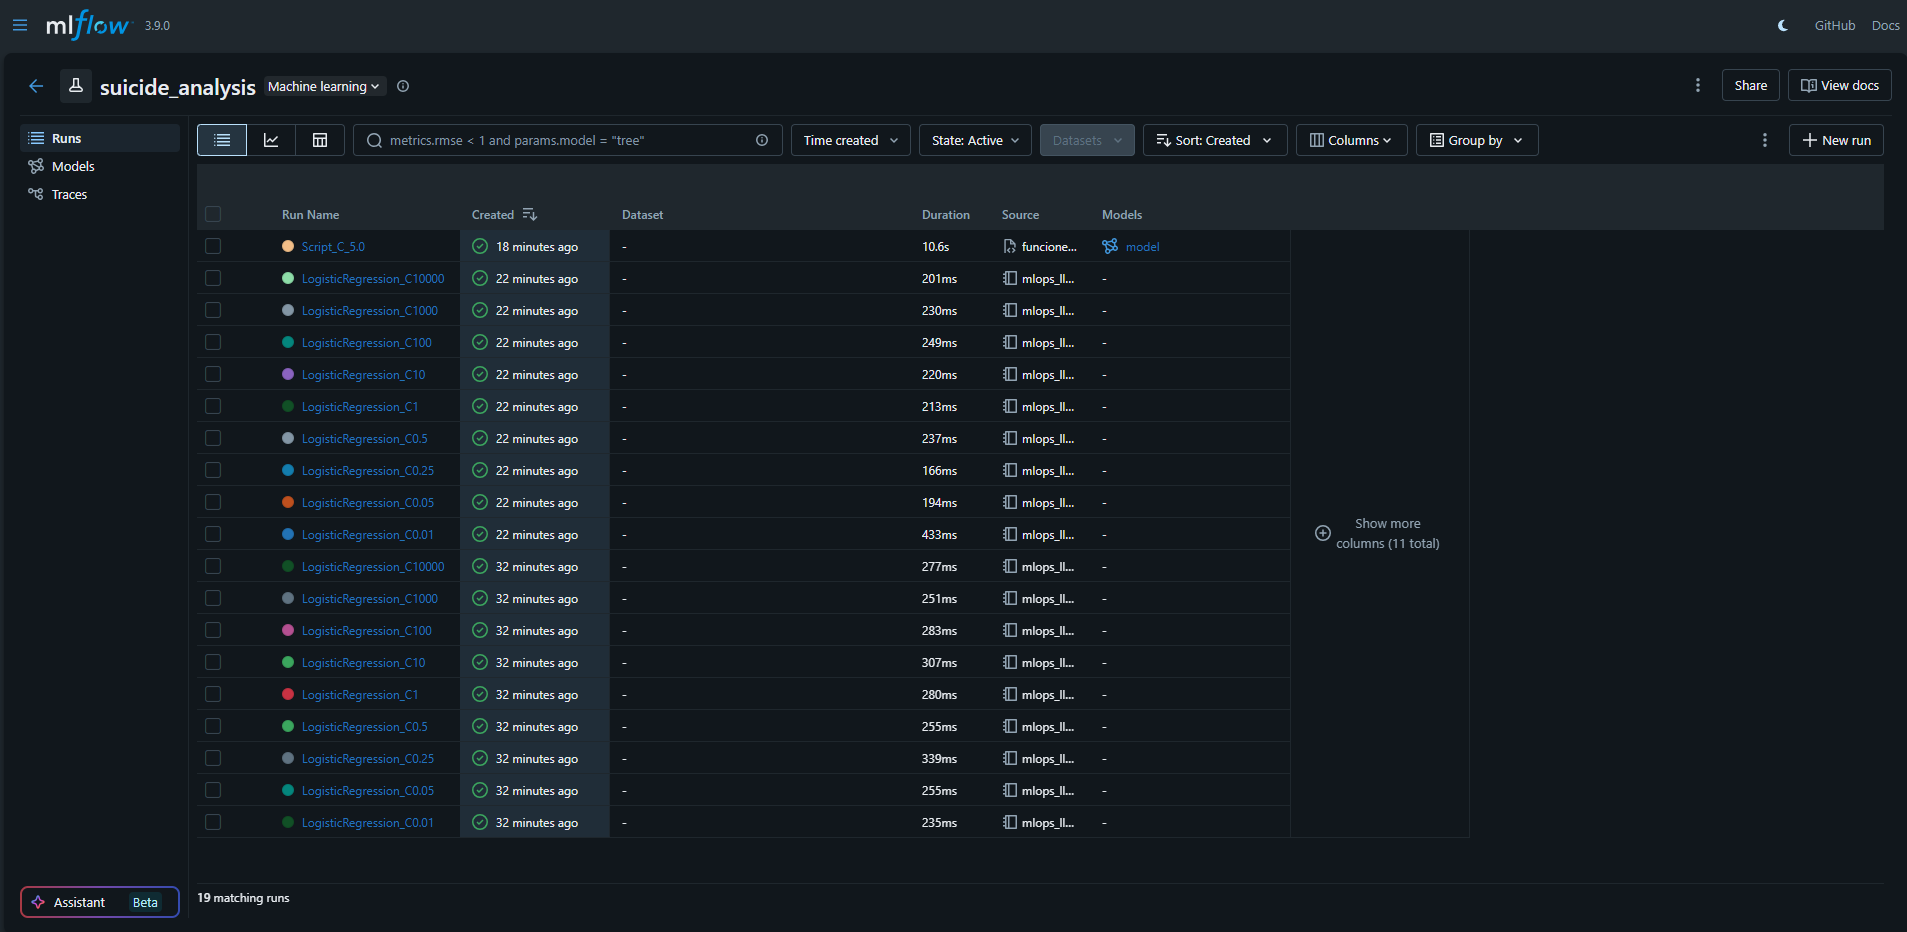

Pruebo el uso de funciones.py haciendo uso en la terminal de: python funciones.py --c 5.0 --max_df 0.8 --min_df 5

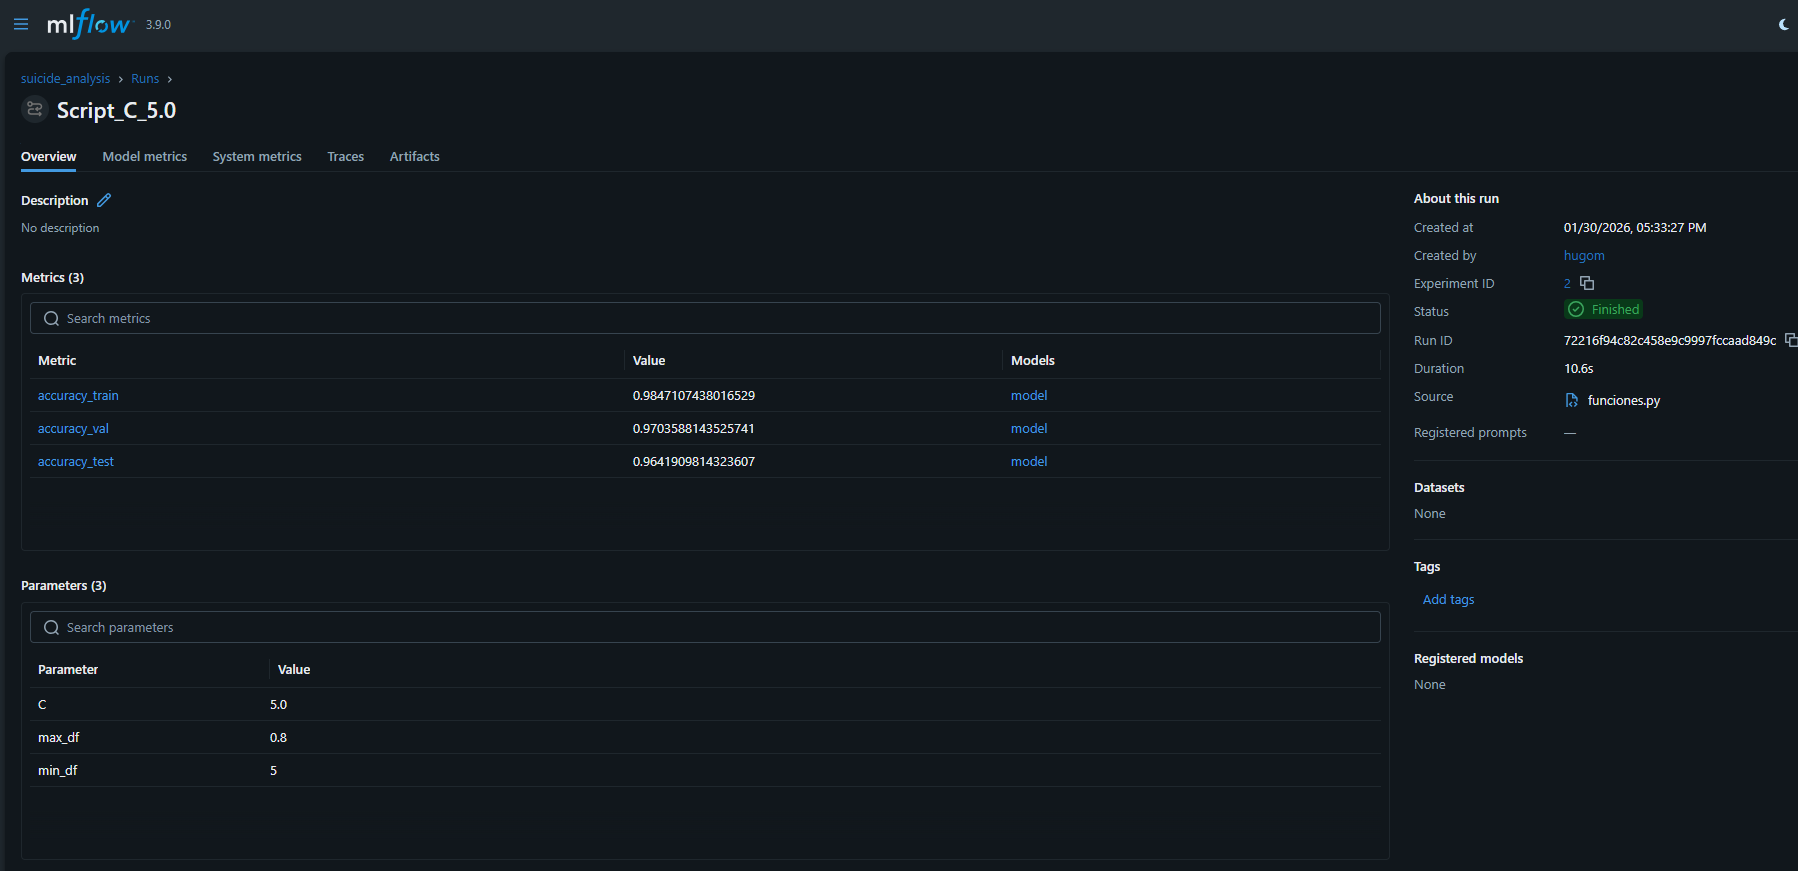

Realizo una comparativa de los diferentes runs:

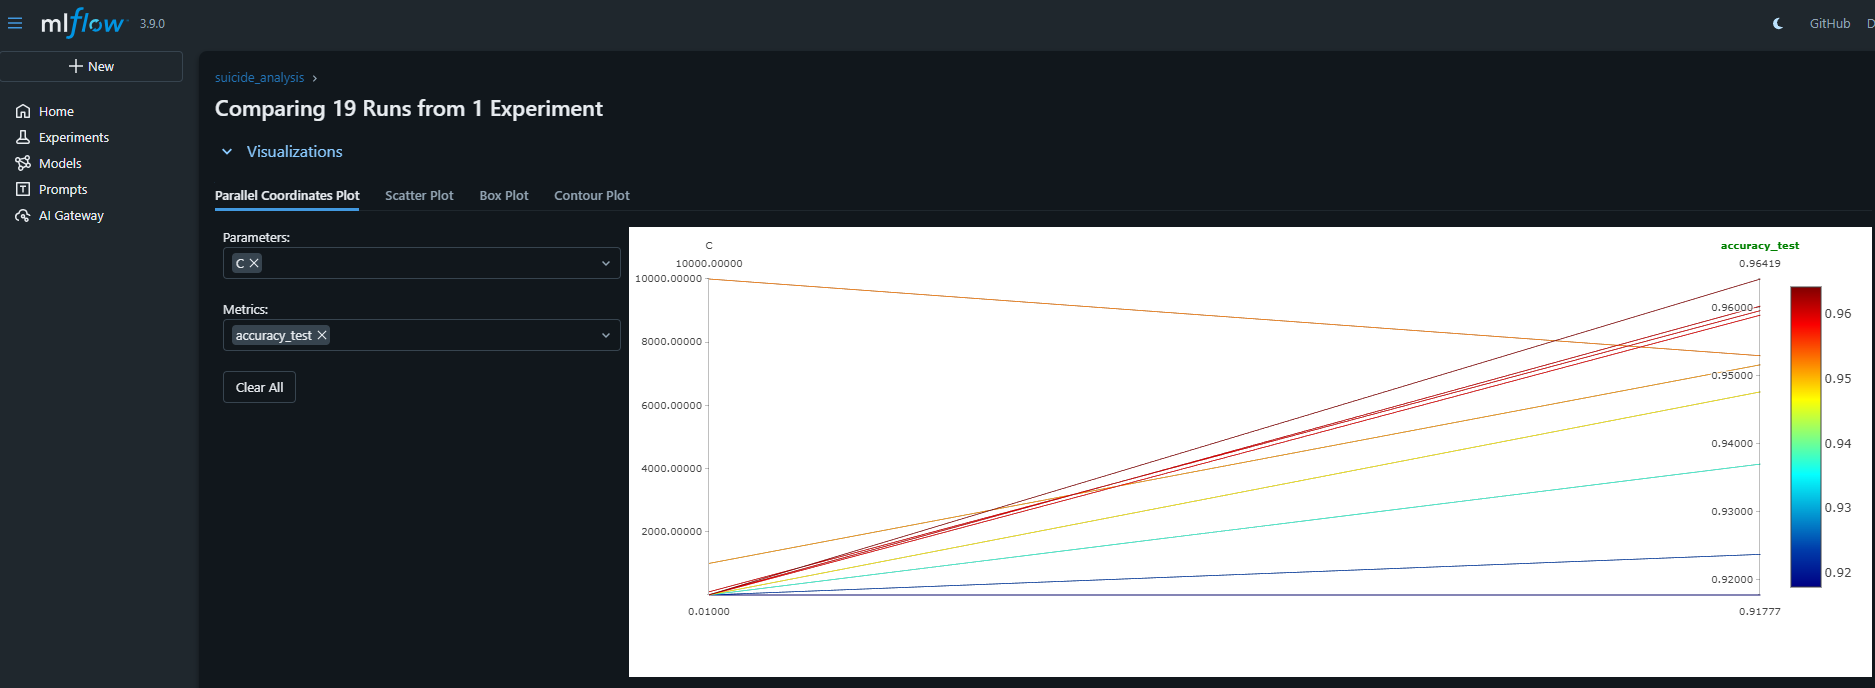

Registro el Script_C_5.0, ya que ha sido el que ha presentado mejores métrica:

In [42]:
model_name = 'suicide-opt-model'
model_mlflow = mlflow.pyfunc.load_model(f'models:/{model_name}/Production')

In [43]:
model_mlflow

mlflow.pyfunc.loaded_model:
  artifact_path: mlflow-artifacts:/2/models/m-0d8eb2c09cc0468aa9c3e261e9287132/artifacts
  flavor: mlflow.sklearn
  run_id: 72216f94c82c458e9c9997fccaad849c

Hago algunas pruebas con el modelo:

In [44]:
texto = "Me siento muy solo y no sé qué hacer con mi vida"
texto = preprocessing_main(texto)

cv_trial = TfidfVectorizer(ngram_range=(1, 3), max_df=0.8, min_df=5)
cv_trial.fit(X_train)
texto = cv_trial.transform([texto])

pred = model_mlflow.predict(texto)

print(f"Resultado de la predicción: {pred}")

Resultado de la predicción: [1]


In [45]:
texto = "Trabajo como ingeniero de datos en una consultora tecnológica"
texto = preprocessing_main(texto)
texto = cv_trial.transform([texto])

pred = model_mlflow.predict(texto)

print(f"Resultado de la predicción: {pred}")

Resultado de la predicción: [0]


In [46]:
texto = "Siento que no le importo a nadie"
texto = preprocessing_main(texto)
texto = cv_trial.transform([texto])

pred = model_mlflow.predict(texto)

print(f"Resultado de la predicción: {pred}")

Resultado de la predicción: [1]


Una vez terminada esta sección, comienzo con el uso de FastAPI. Para llamar a la API, ejecuto en la terminal: uvicorn main:app --reload.

Adjunto capturas de:

- La pantalla docs con 5 módulos.

- Cada uno de los módulos con la respuesta dentro de docs. 

- Cada uno de los módulos en la llamada https.

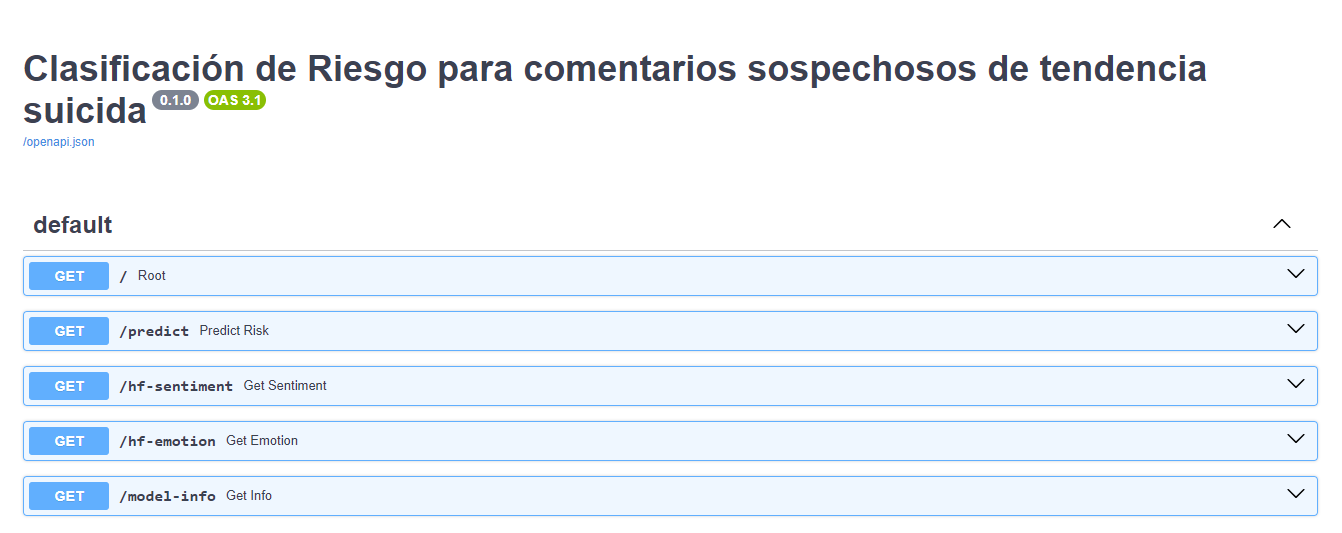

---------------------------------------

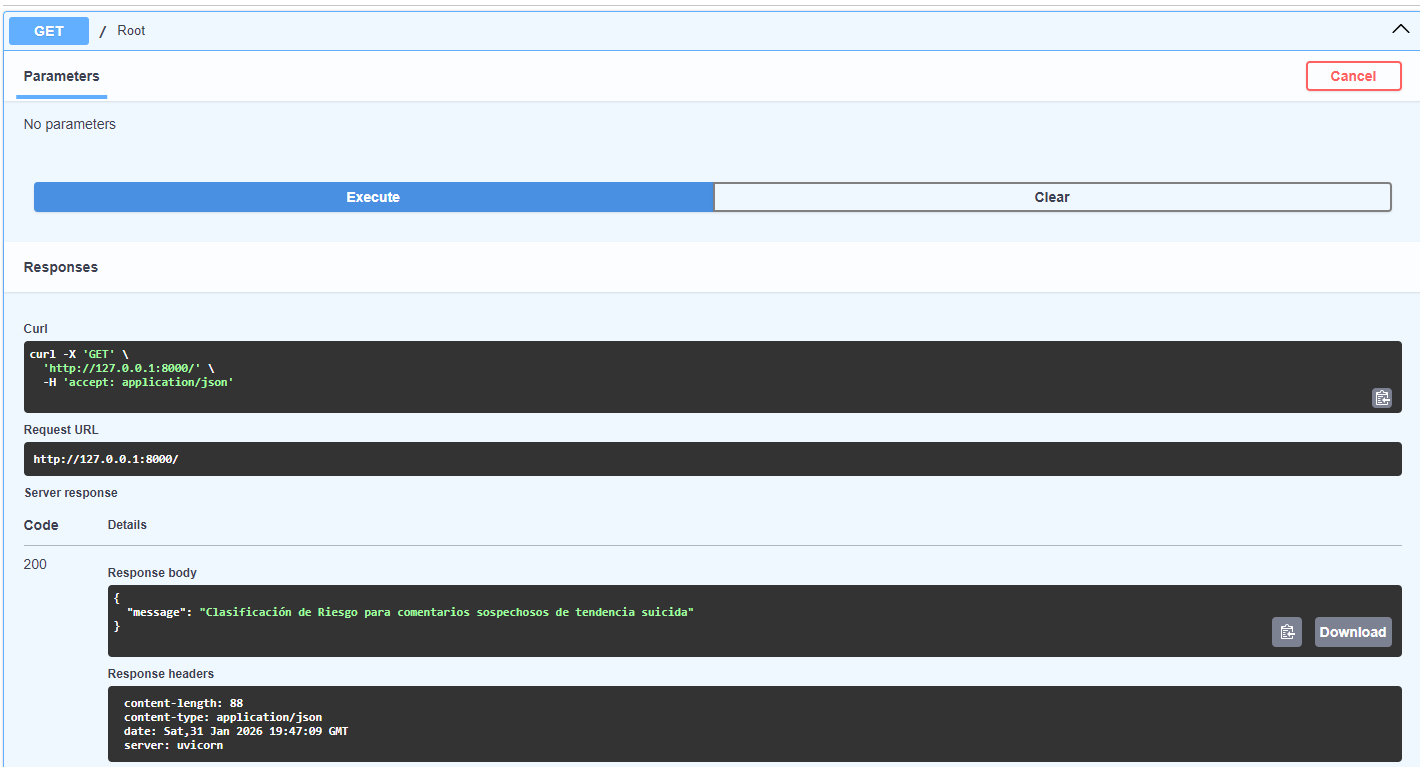

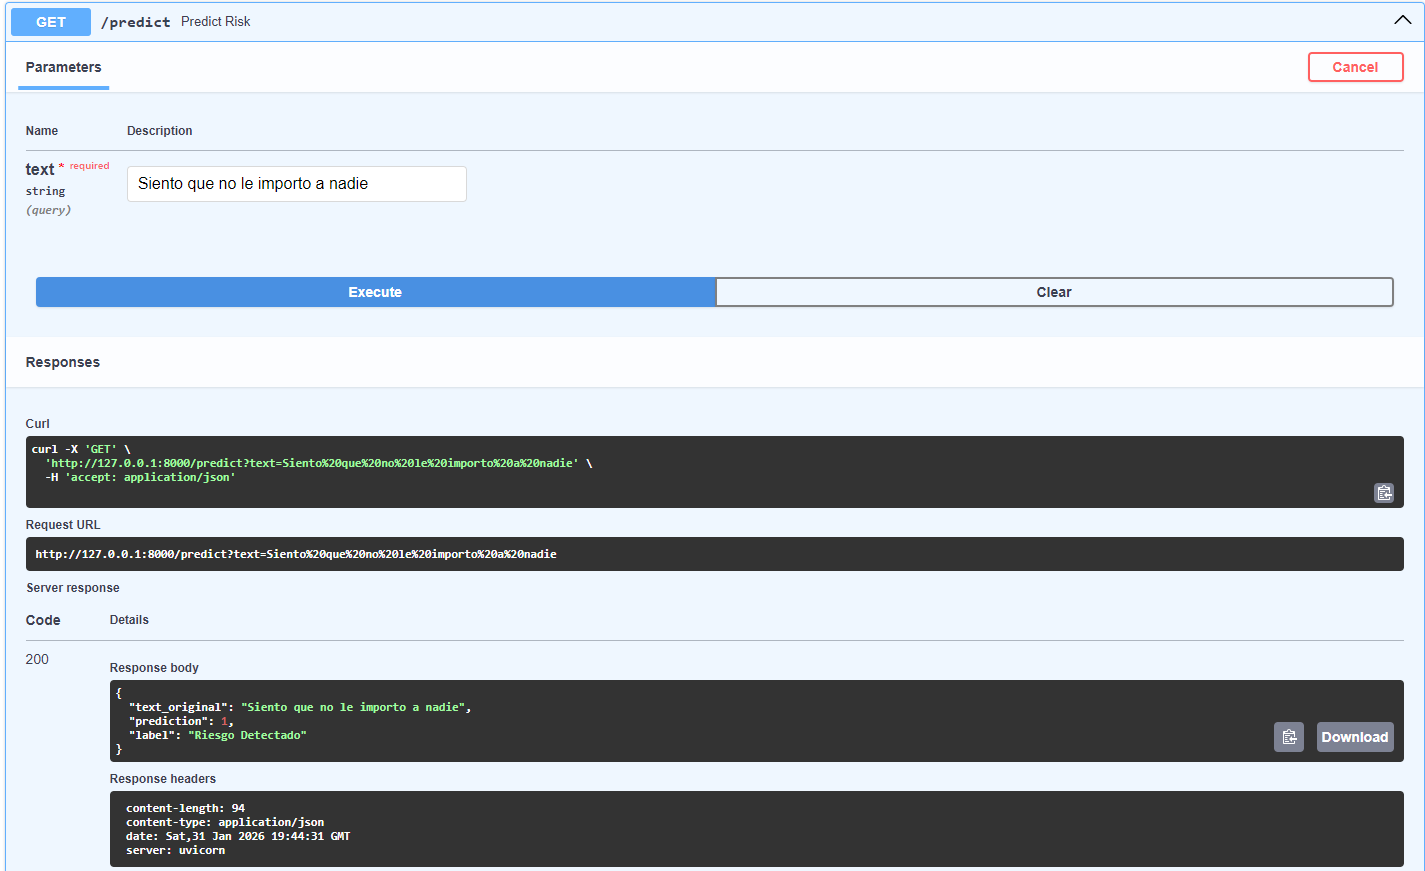

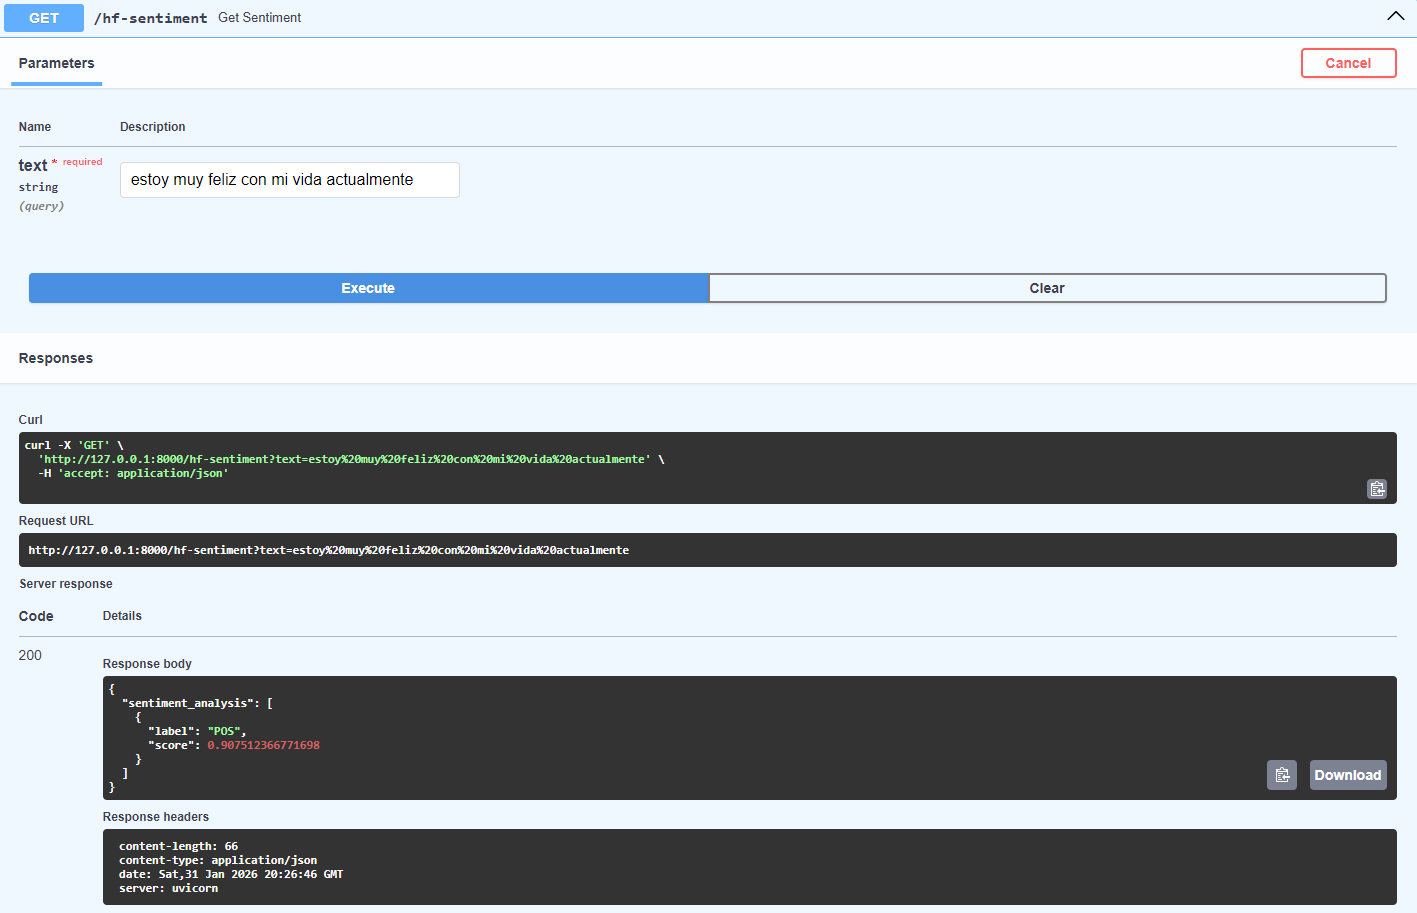

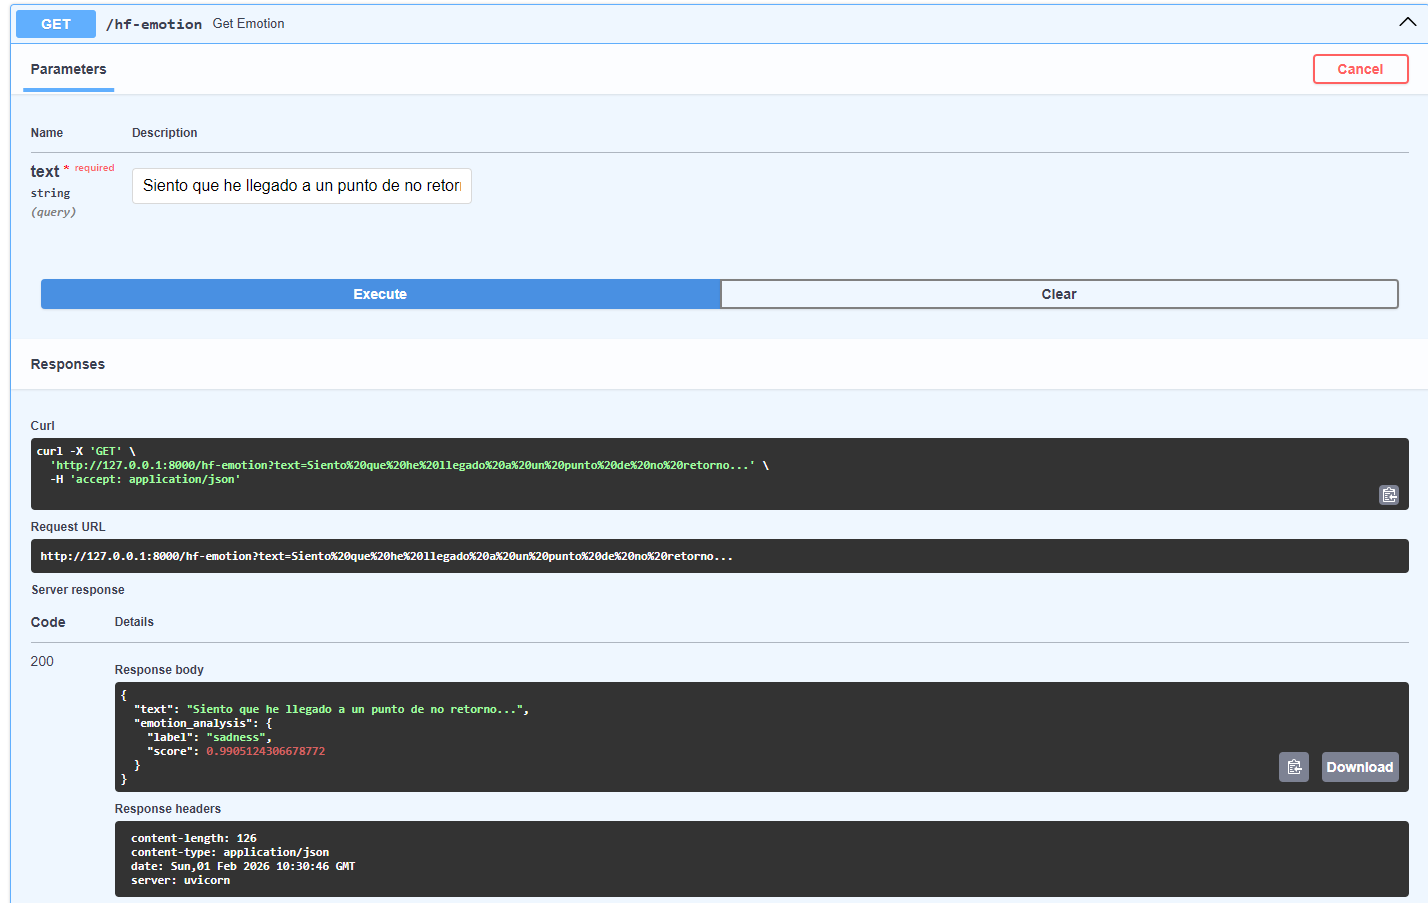

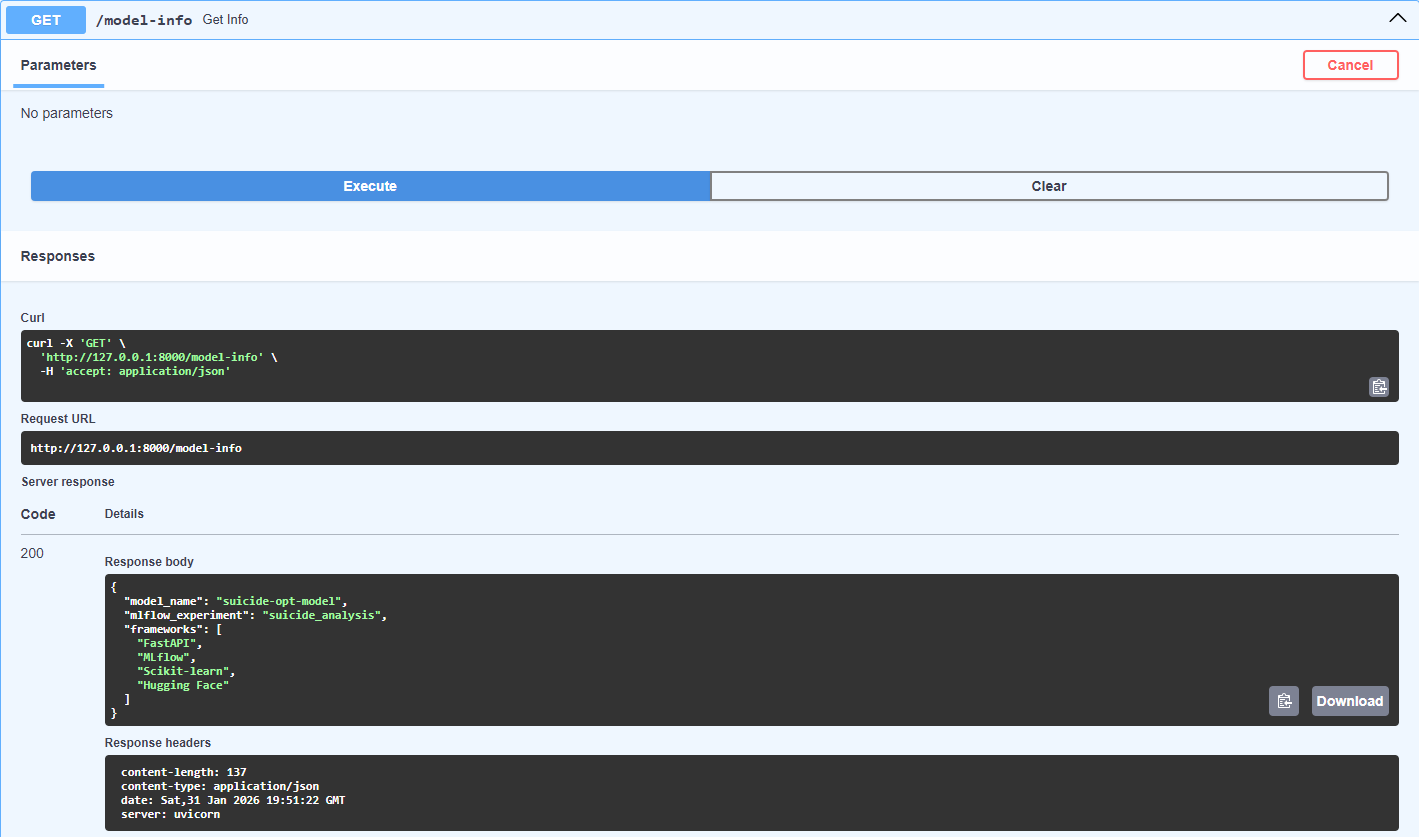

----------------------

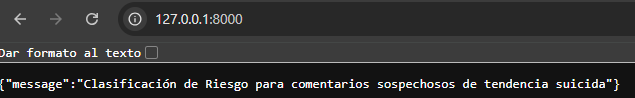

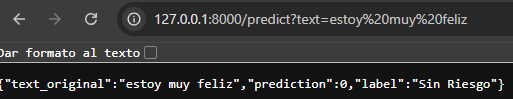

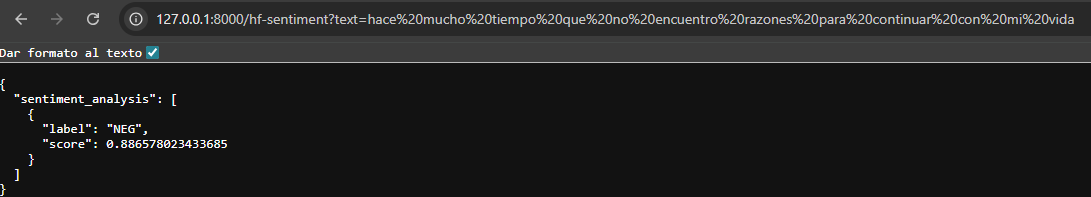

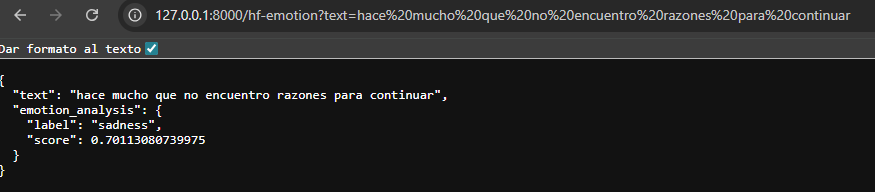

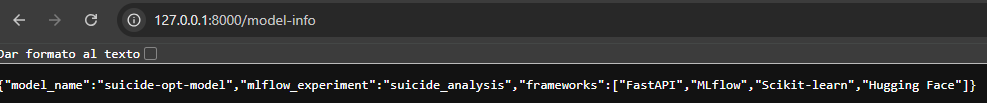